In [44]:
import sys
import numpy as np

np.random.seed(10)

sys.path.append("../")
import pandas as pd
import os

from sklearn.model_selection import train_test_split
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import src.preprocessing as pp
pd.get_option("display.max_rows")

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import lightgbm as lgb
import shap
from sklearn.model_selection import GridSearchCV

import src.visualisations as vis

In [45]:
identifiers = ["date_id_a", "match_a", "wave_a", 
"date_id_b",  "wave_b"]

# same as 1_1
#preference = ["pf_o_att_a", "pf_o_sin_a", "pf_o_int_a", "pf_o_fun_a", "pf_o_amb_a", "pf_o_sha_a", 
#"pf_o_att_b", "pf_o_sin_b", "pf_o_int_b", "pf_o_fun_b", "pf_o_amb_b", "pf_o_sha_b"]

personal_info = ["field_cd_a", "age_a", "race_a", "income_a", "zipcode_a", "samerace_a", "goal_a",
"field_cd_b", "age_b", "race_b", "income_b", "zipcode_b", "goal_b", "distance_bin", "zipcode_area_b", "zipcode_area_a"]

behaviour = ["go_out_a", "sports_a", "tvsports_a", "exercise_a", "dining_a", "museums_a", "art_a", "hiking_a", "gaming_a",
           "clubbing_a", "reading_a", "tv_a", "theater_a", "movies_a", "concerts_a", "music_a", "shopping_a",
           "yoga_a", "exphappy_a",
           "go_out_b", "sports_b", "tvsports_b", "exercise_b", "dining_b", "museums_b", "art_b", "hiking_b", "gaming_b",
           "clubbing_b", "reading_b", "tv_b", "theater_b", "movies_b", "concerts_b", "music_b", "shopping_b",
           "yoga_b", "exphappy_b"]

difference_hobbies = ["go_out_df", "sports_df", "tvsports_df", "exercise_df", "dining_df", "museums_df", "art_df", "hiking_df", "gaming_df",
           "clubbing_df", "reading_df", "tv_df", "theater_df", "movies_df", "concerts_df", "music_df", "shopping_df", "yoga_df", "exphappy_df"]

hobbies_big_diff = ["go_out_df_big", "sports_df_big", "tvsports_df_big", "exercise_df_big", "dining_df_big", "museums_df_big", "art_df_big", "hiking_df_big", "gaming_df_big",
           "clubbing_df_big", "reading_df_big", "tv_df_big", "theater_df_big", "movies_df_big", "concerts_df_big", "music_df_big", "shopping_df_big", "yoga_df_big", "exphappy_df_big"]

looking_for = ["attr1_1_a", "sinc1_1_a", "intel1_1_a", "fun1_1_a", "amb1_1_a", "imprace_a", "imprelig_a",
"attr1_1_b", "sinc1_1_b", "intel1_1_b", "fun1_1_b", "amb1_1_b", "imprace_b", "imprelig_b"]

self_rating = [ "attr3_1_a", "sinc3_1_a", "intel3_1_a", "fun3_1_a", "amb3_1_a", "attr3_1_b", "sinc3_1_b", "intel3_1_b", "fun3_1_b", "amb3_1_b"]

# difference between what person a i slooking for b what person a rates themselves 1_1_a and 3_1_b
difference = ["attr_b_a", "sinc_b_a", "intel_b_a", "fun_b_a", "amb_b_a", "attr_a_b", "sinc_a_b", "intel_a_b", "fun_a_b", "amb_a_b"]

to_drop = ["date_id_a", "date_id_b", "wave_a", "wave_b", "zipcode_a", "zipcode_b"] #TODO clean text in from column , 

to_keep = personal_info + identifiers + difference + hobbies_big_diff + difference_hobbies + ["both_creative", "both_sporty"]

categorical = ["income_a", "income_b", "distance_bin", "zipcode_area_a", "zipcode_area_b", "race_a", "race_b"]

In [46]:
# read in data
df = pd.read_csv("../data/interim/single_row_date.csv")
df = df[to_keep]
df.drop(to_drop, axis = 1, inplace = True)

x = df.match_a.value_counts()
x[0]/(x[1]+x[0])

0.834248455730954

In [47]:
df = pd.get_dummies(df, columns = categorical)

In [48]:
# replace "Not applicable" with -1
df.columns[df.isnull().any()].tolist()
df.isnull().sum().sort_values(ascending=False).head(10)
df.dropna(inplace=True)

In [49]:
X = df[[column for column in df.columns if column!="match_a"]]
y = df["match_a"]

In [50]:
# splitting the data into testing and training sets. 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.30, stratify=y, shuffle=True
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("baseline accuracy:", (len(y_test)-sum(y_test))/len(y_test))

(2039, 118) (2039,)
(875, 118) (875,)
baseline accuracy: 0.8342857142857143


### Look at performance of a baseline model

Precision: 0.48148148148148145
Recall: 0.0896551724137931
Accuracy: 0.8331428571428572
F1 Score: 0.1511627906976744


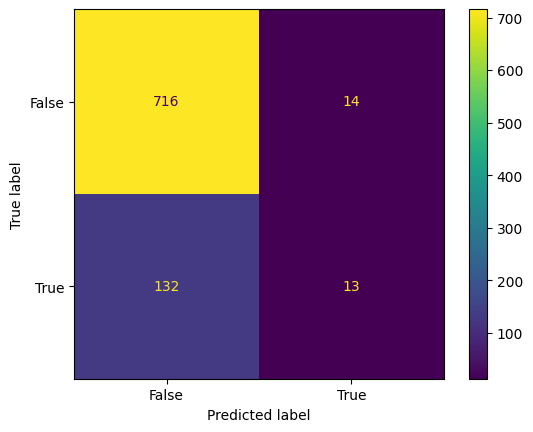

In [51]:
# default
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
pp.scoring_func(y_test, clf.predict(X_test))

### Look at upsampling for baseline model

In [52]:
# create dataframe which only contains training data to do the upsampling on
train_df = X_train.copy()
train_df["match_a"] = y_train

In [53]:
# looking for best performing upsample multiplier
# for m in np.arange(4.0, 10.0, 0.25):
#     print("Upsample multiplier: ", m)
#     pp.resample_data(train_df, m, X_test, y_test, lgb.LGBMClassifier())

X_train shape is:  (4151, 118) X_train shape is:  (4151,)
Precision: 0.34782608695652173
Recall: 0.2206896551724138
Accuracy: 0.8022857142857143
F1 Score: 0.270042194092827


(LGBMClassifier(random_state=42),
       field_cd_a      age_a  samerace_a    goal_a  field_cd_b  age_b  goal_b  \
 2426   10.000000  25.000000           1  5.000000         2.0   36.0     3.0   
 830     7.000000  28.000000           0  2.000000         2.0   22.0     1.0   
 1088   13.000000  23.000000           0  2.000000         8.0   26.0     2.0   
 1850    7.000000  24.000000           1  2.000000        10.0   34.0     2.0   
 2862   11.000000  29.000000           0  2.000000         5.0   24.0     1.0   
 ...          ...        ...         ...       ...         ...    ...     ...   
 1349   13.000000  28.000000           0  2.000000        10.0   24.0     3.0   
 882     8.000000  28.000000           0  1.000000        10.0   22.0     2.0   
 629     3.000000  26.000000           0  1.000000         8.0   26.0     1.0   
 1891   11.000000  23.000000           0  2.000000         8.0   28.0     1.0   
 123     7.662488  26.358928           0  2.122063         8.0   28.0     6

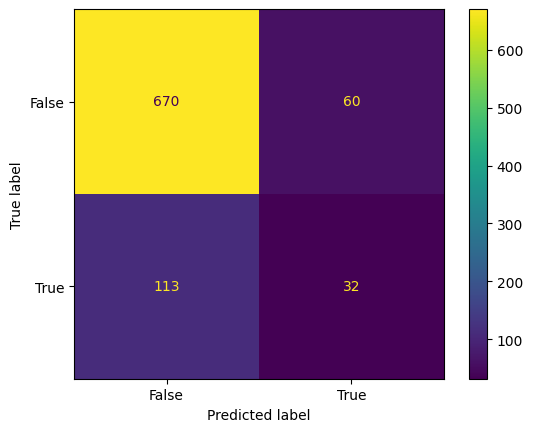

In [54]:
# the above multipliers were tried
# best performing found to be at 2.5
pp.resample_data(train_df, 7.25, X_test, y_test, lgb.LGBMClassifier(random_state=42))

### Add hyperparameter tuning to improve model
#### No Upsampling
**Optimising F1 Score**

In [55]:
# print("X_train shape is: ", X_train.shape, "X_train shape is: ", y_train.shape)

# model = lgb.LGBMClassifier()
# hyperparams = dict(application=["binary"],
#                    objective=["binary"],
#                    metric=["f1_micro", "logloss", "auc", "accuracy"],
#                    boosting_type=["gbdt", "dart", "rf"],
#                    num_leaves=[5, 7, 31],#, 1000, 4095
#                    scale_pos_weight=[1, 50, 100], #, 300, 10000
#                    min_child_weight =[0.01, 100],
#                    subsample = [0.4, 1],
#                    colsample_bytree = [0.4, 1],
#                    feature_fraction=[0.5, 0.6],
#                    bagging_fraction=[0.5, 0.7],
#                    verbose=[0],
#                    random_state=[42]
#                    )
# clf = GridSearchCV(model, hyperparams, scoring="f1_micro", verbose=0, cv=5, n_jobs=1)
# best_model = clf.fit(X_train, y_train)

In [56]:
#clf.best_estimator_.get_params()

In [57]:
best_params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.4,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.01,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 7,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 0.4,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'application': 'binary',
 'bagging_fraction': 0.5,
 'feature_fraction': 0.5,
 'metric': 'f1_micro',
 'scale_pos_weight': 1,
 'verbose': 0}

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Precision: 0.6
Recall: 0.041379310344827586
Accuracy: 0.8365714285714285
F1 Score: 0.07741935483870968


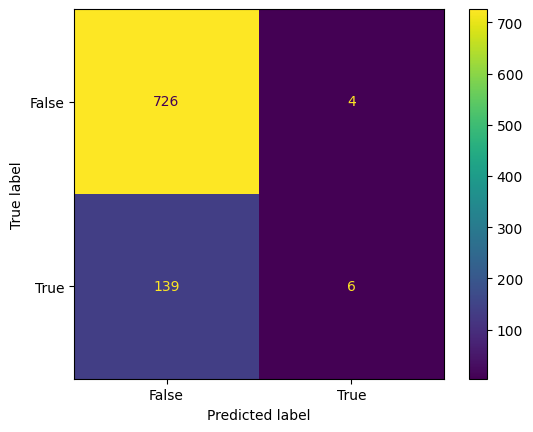

In [58]:
best_model = lgb.LGBMClassifier(**best_params) #clf.best_estimator_.get_params()
best_model.fit(X_train, y_train)
pp.scoring_func(y_test, best_model.predict(X_test)) 

Accuracy and precision are high.
Precision is defined as the ratio between all the instances that were correctly classified in the positive class against the total number of instances classified in the positive class. In other words, it's the percentage of the instances classified in the positive class that is actually right.
We can assume that people who go speed dating are open to meeting new people, but they don't want to miss getting paired with their sole mate! Therefore, we'd rather predict more dates to be matches than the other way around.

#### Use best sampling from baseline model with hyperparameters tuned

X_train shape is:  (4151, 118) X_train shape is:  (4151,)
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.4 will be ignored. Current va

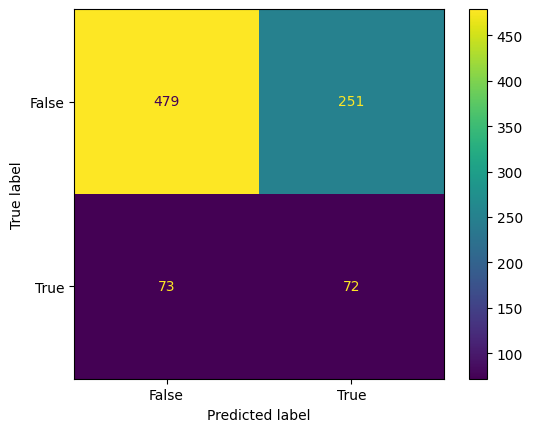

In [59]:
# create dataframe which only contains training data to do the upsampling on
train_df = X_train.copy()
train_df["match_a"] = y_train

clf_resample, test_data = pp.resample_data(train_df, 7.25, X_test, y_test, best_model)

In [60]:
test_data["correct"] = np.where(test_data["y_pred"] != test_data["y_actual"], 0, 1)

In [61]:
# look at mistakes
test_data.to_excel("../data/interim/model_mistakes_full.xlsx")

## Plot Feature Importance


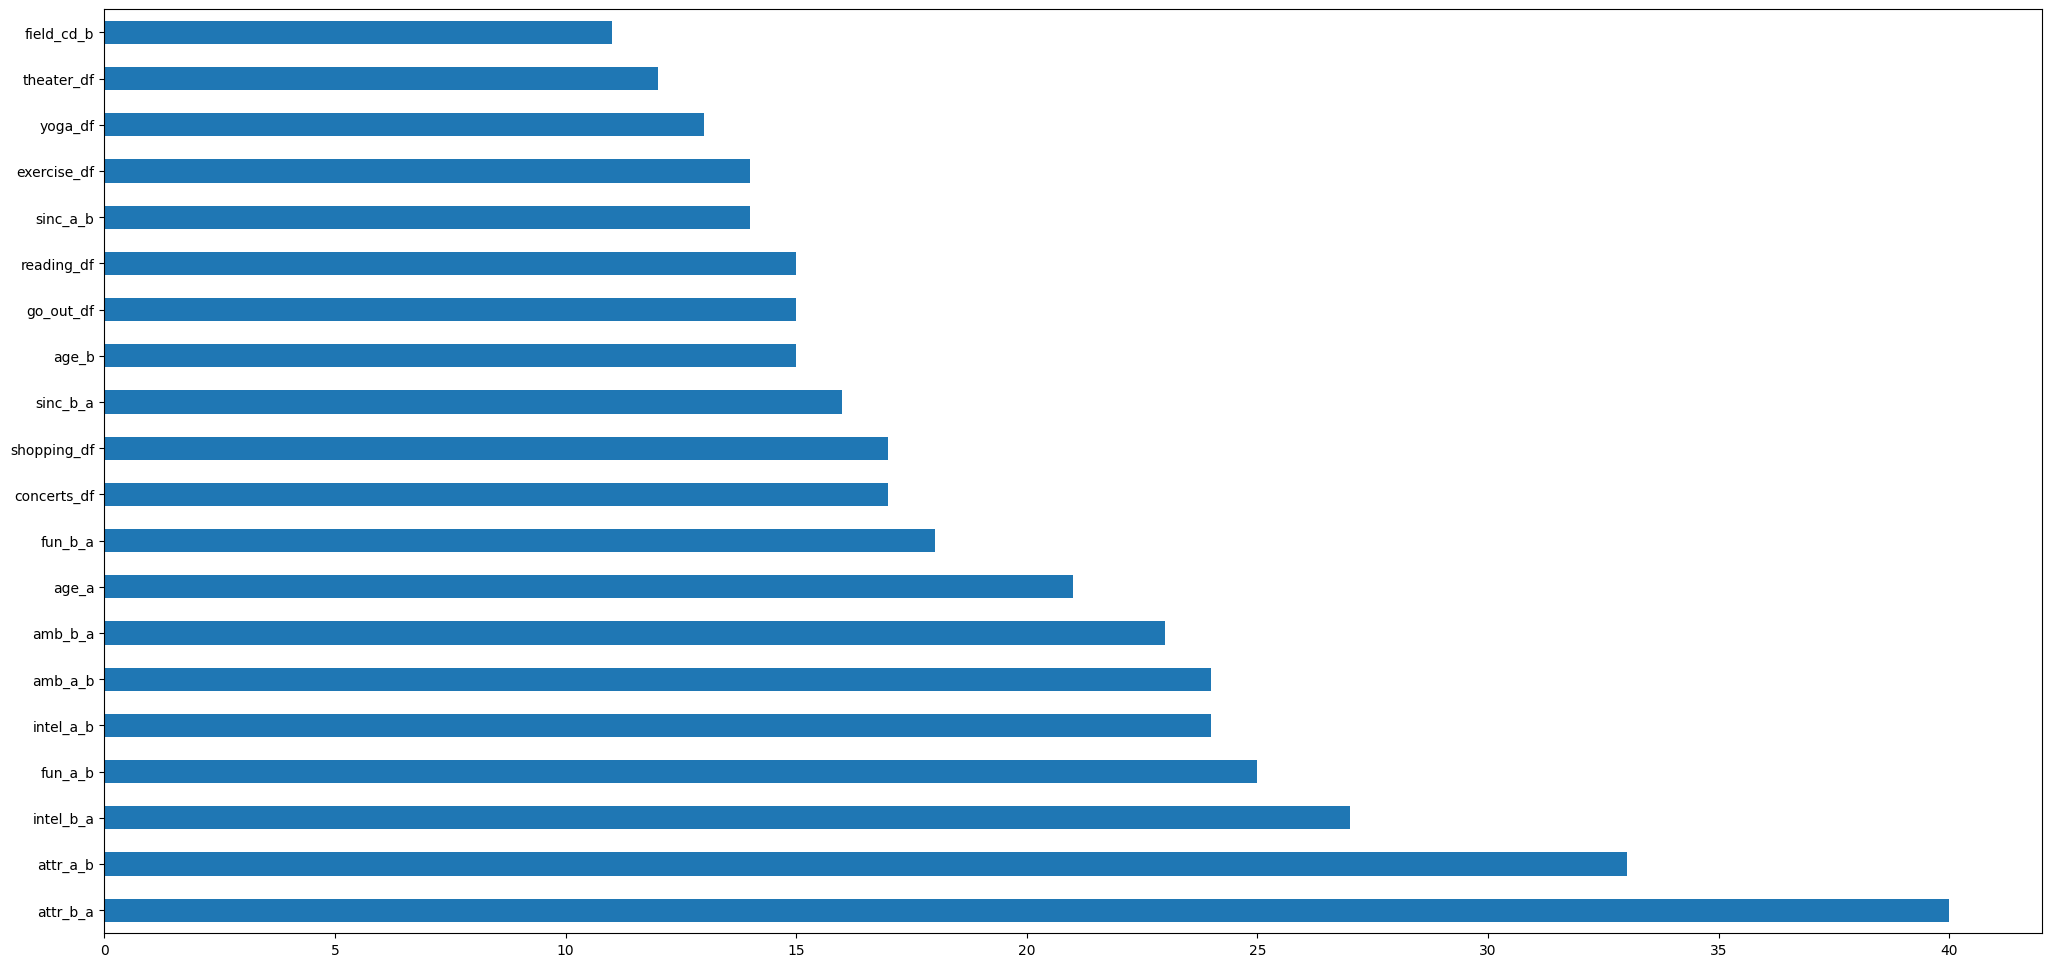

In [62]:
# first method uses lightgbm built in feature extraction
plt_lgbm, feat_imp_lgbm = vis.gen_lgbm_feat_importance(clf_resample, 20)

c:\Users\hannah.alexander\Anaconda3\envs\speed_date_env\lib\site-packages\shap\explainers\_tree.py:353: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray

c:\Users\hannah.alexander\Anaconda3\envs\speed_date_env\lib\site-packages\shap\plots\_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



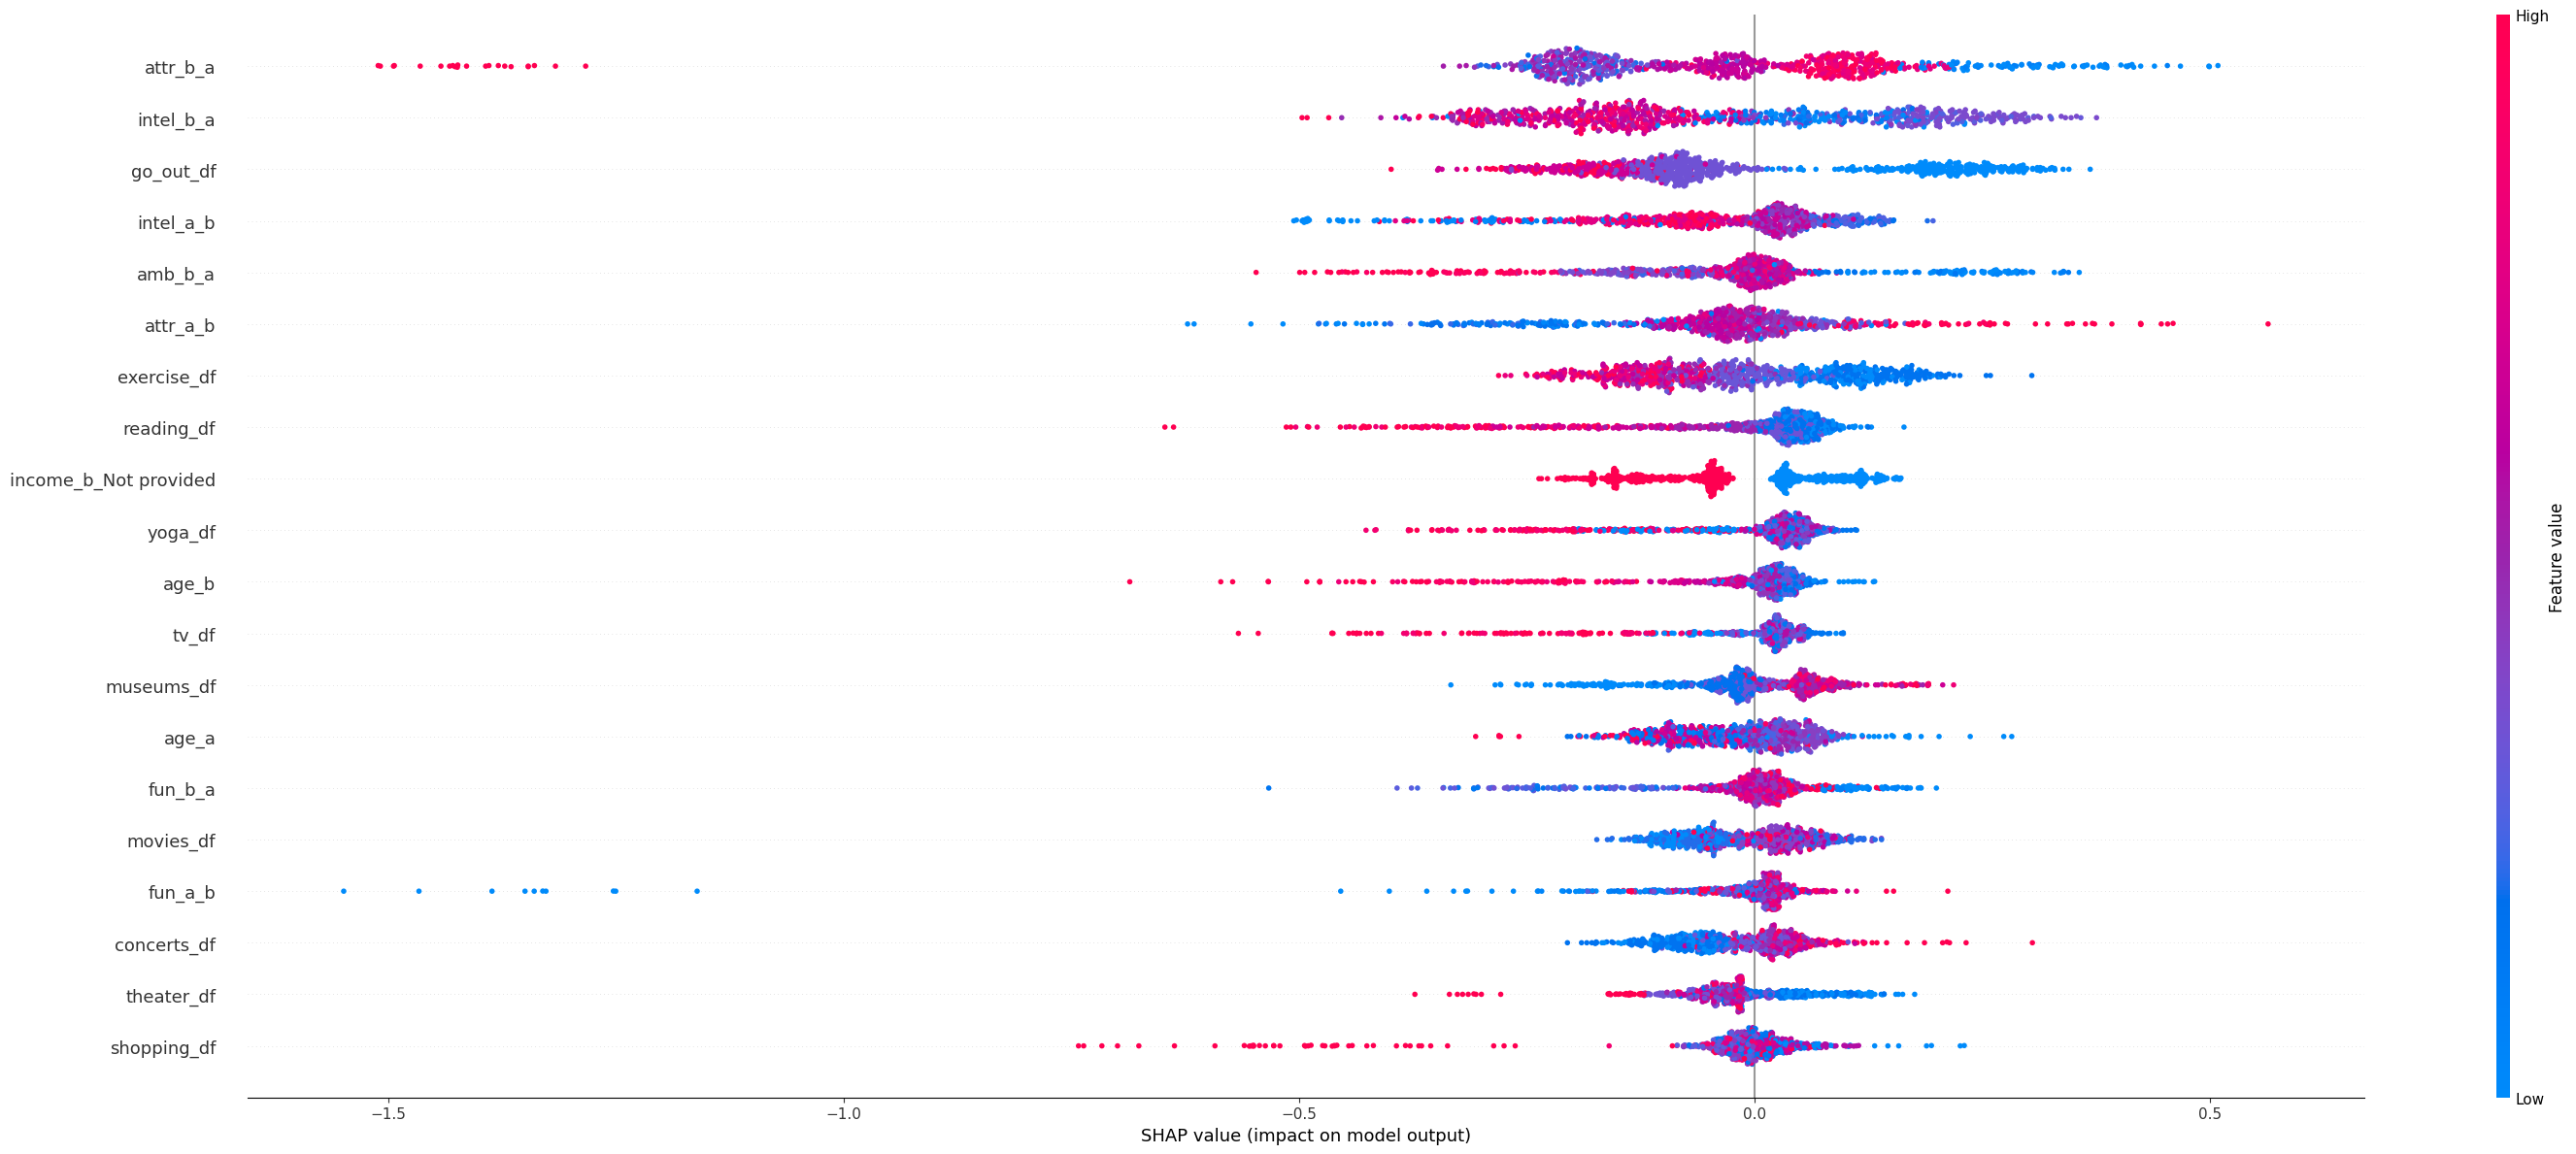

     col_name  feature_importance_vals
7    attr_b_a                 0.179584
9   intel_b_a                 0.165929
36  go_out_df                 0.150140
14  intel_a_b                 0.101744
11    amb_b_a                 0.100424


In [63]:
# second method used SHAP feature importance
plt_shap, feat_imp_shap = vis.gen_shap_summary_plot(clf_resample, X_test)

In [64]:
total_shap = feat_imp_shap["feature_importance_vals"].sum()
feat_imp_shap["shap_val_normalised"] = feat_imp_shap["feature_importance_vals"]/ total_shap

feat_imp_lgbm = pd.DataFrame(feat_imp_lgbm).reset_index()
feat_imp_lgbm = feat_imp_lgbm.rename(columns = {"index": "col_name", 0: "feature_importance_vals"})

total_lgbm = feat_imp_lgbm["feature_importance_vals"].sum()
feat_imp_lgbm["lgbm_val_normalised"] = feat_imp_lgbm["feature_importance_vals"]/ total_lgbm

ranking_df = pd.merge(feat_imp_shap, feat_imp_lgbm, on= "col_name")

ranking_df["Overall"] = (ranking_df["shap_val_normalised"] + ranking_df["lgbm_val_normalised"])/2

ranking_df = ranking_df.sort_values("Overall", ascending = False)
ranking_df.to_excel("../reports/lightgbm_feat_imp.xlsx")

In [65]:
fig = px.bar(ranking_df, x = "col_name", y = "Overall", width=1200, height=1000)
fig.update_layout(title = "Feature Significance", yaxis_title= "Importance", xaxis_title = "Feature")
fig.show()

In [ ]:
# error analysis
from raiwidgets import ErrorAnalysisDashboard
predictions = clf_resample.predict(X_test)
features = X_train.columns
ErrorAnalysisDashboard(dataset=X_test, true_y=y_test, features=features, pred_y=predictions)